In [35]:
import torch
from torch.autograd import grad
from transformers.models.gpt2 import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import transformers
from transformers import AutoTokenizer
from dataset import GPT2Dataset, GPT2DatasetReplace, TestDataset
from tqdm import tqdm
import random
import numpy as np
import json
import re
import os

In [36]:
device = "cuda:0"
task = "add_ood"
cot = True
number = "a100_b100_3hole"

In [37]:
print("loading model...")
model_name = "gpt2"
if cot:
    model = GPT2LMHeadModel.from_pretrained(f"save_model_{model_name}/{task}/{number}_cot/model_99").to(device)
else:
    model = GPT2LMHeadModel.from_pretrained(f"save_model_{model_name}/{task}/{number}/model_99").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("pretrained_models/gpt2")
print("done!")

if cot:
    file_path_test=f'datasets/{task}/{number}/test_cot.json'
    file_path_train=f'datasets/{task}/{number}/train_cot.json'
else:
    file_path_test=f'datasets/{task}/{number}/test.json'
    file_path_train=f'datasets/{task}/{number}/train.json'

with open(file_path_test, "r") as f:
    test_set = json.load(f)

with open(file_path_train, "r") as f:
    train_set = json.load(f)

loading model...
done!


In [38]:
def get_token_id(number: int):
    '''
    get the token_id for the number
    '''
    token_id = tokenizer(str(number)).input_ids
    assert len(token_id) == 1
    return token_id[0]

In [39]:
# we use the parameters corresponding to 0~99 in the last classification layer as \theta
w = model.lm_head.weight
token_ids = torch.tensor([get_token_id(n) for n in range(100)]).to(device)
theta = torch.index_select(w, 0, token_ids)

In [40]:
def hessian_vector_product(y,v):
    """
    Arguments:
        y: 标量/tensor，通常来说为loss函数的输出
        v: pytorch tensor的list，代表需要与hessian矩阵乘积的向量
    Returns:
        return_grads: pytorch tensor的list, 代表hvp的最终结果.
    Raises:
        ValueError: y 与 w 长度不同."""
    model.zero_grad()
    first_grads = grad(y, model.lm_head.weight, retain_graph=True, create_graph=True)[0]
    a = torch.index_select(first_grads, 0, token_ids).reshape(-1) @ v
    a.backward()
    return torch.index_select(model.lm_head.weight.grad, 0, token_ids).reshape(-1)

def extract_inputs_from_dataset(idx, dataset):
    sample = dataset[idx]["question"]+dataset[idx]["answers"][0]
    inputs = tokenizer(sample, return_tensors='pt').input_ids
    return inputs

def get_nabla_theta_L(z, alpha=1):
    r'''
    get $\nabla_{\theta}L(z, \theta)$
    '''
    model.zero_grad()
    outputs = model(z, labels=z)
    loss = outputs.loss
    loss = loss * alpha
    loss.backward()
    g = torch.index_select(model.lm_head.weight.grad, 0, token_ids)
    return g.reshape(-1)

In [41]:
def get_hv(test_idx, Hv=None, damp=0.01, alpha=1, iter_times=100, sample_num=1):
    model.zero_grad()
    z_test = extract_inputs_from_dataset(test_idx, test_set).to(device)
    v = get_nabla_theta_L(z_test, alpha).to(device)
    if Hv == None:
        Hv = v.to(device)
    Hv_list = []
    # start iteration
    # H_j^{-1}v = v + (I-\nabla^2_\theta L(z_{sj}, \theta))H_{j-1}^{-1}v
    for iter_time in tqdm(range(iter_times)):
        hvp = torch.zeros_like(v)
        # sample z_sj from training set
        for _ in range(sample_num):
            model.zero_grad()
            sj = random.randint(0, len(train_set)-1)
            z_sj = extract_inputs_from_dataset(sj, train_set).to(device)
            loss = model(z_sj, labels = z_sj).loss
            loss = loss * alpha
            hvp += hessian_vector_product(loss, Hv)
        Hv = v + (1-damp) * Hv - hvp / sample_num
        Hv_list.append(Hv[0].item())
        if iter_time % (iter_times/10) == 0:
            print("="*20 + f" iter: {iter_time} "+"="*20)
            # print(Hv)
            print(f"$\Delta$ = {torch.norm(v - hvp/sample_num)}")
    return Hv, Hv_list

def calc_IF(train_idx, Hv):
    z_train = extract_inputs_from_dataset(train_idx, train_set).to(device)
    nabla_theta_L_train = get_nabla_theta_L(z_train).to(device)
    return - Hv @ nabla_theta_L_train


In [42]:
def get_influence_factor(train_idx, test_idx, alpha=1, iter_times=100, sample_num=1, wn="model.transformer.h[11].mlp.c_fc"):
    model.zero_grad()
    z_test = extract_inputs_from_dataset(test_idx, test_set).to(device)
    z_train = extract_inputs_from_dataset(train_idx, train_set).to(device)
    nabla_theta_L_train = get_nabla_theta_L(z_train).to(device)
    v = get_nabla_theta_L(z_test).to(device)
    Hv = v.to(device)
    IF_list = []
    # start iteration
    # H_j^{-1}v = v + (I-\nabla^2_\theta L(z_{sj}, \theta))H_{j-1}^{-1}v
    for iter_time in tqdm(range(iter_times)):
        hvp = torch.zeros_like(v)
        # sample z_sj from training set
        for _ in range(sample_num):
            model.zero_grad()
            sj = random.randint(0, len(train_set)-1)
            z_sj = extract_inputs_from_dataset(sj, train_set).to(device)
            loss = model(z_sj, labels = z_sj).loss
            loss = loss * alpha
            hvp += hessian_vector_product(loss, Hv, wn)
        Hv = v + Hv - hvp / sample_num
        IF_list.append((- Hv @ nabla_theta_L_train).item())
        # if iter_time % 200 == 0:
        #     print("="*20 + f" iter: {iter_time} "+"="*20)
        #     # print(Hv)
        #     print(f"$\Delta$ = {torch.norm(v - hvp/sample_num)}")
    return IF_list[-1], IF_list        
    # return - Hv @ nabla_theta_L_train

In [43]:
test_idx = 0

In [44]:
a_range = int(np.sqrt(len(test_set) + len(train_set)))
print(test_set[test_idx]["question"])

5+17=


In [45]:
alpha = 0.01
iter_times = 10000
Hv, Hv_list = get_hv(test_idx, alpha=alpha, iter_times=iter_times)

  0%|          | 2/10000 [00:00<10:58, 15.19it/s]

==================== iter: 0 ====================
$\Delta$ = 0.008428238332271576


 10%|█         | 1002/10000 [01:08<09:30, 15.76it/s]

==================== iter: 1000 ====================
$\Delta$ = 0.007007988169789314


 20%|██        | 2003/10000 [02:16<10:27, 12.74it/s]

==================== iter: 2000 ====================
$\Delta$ = 0.007035189773887396


 30%|███       | 3003/10000 [03:25<07:51, 14.84it/s]

==================== iter: 3000 ====================
$\Delta$ = 0.007260085083544254


 40%|████      | 4003/10000 [04:34<07:53, 12.67it/s]

==================== iter: 4000 ====================
$\Delta$ = 0.008429872803390026


 50%|█████     | 5003/10000 [05:46<05:33, 14.99it/s]

==================== iter: 5000 ====================
$\Delta$ = 0.007260242942720652


 60%|██████    | 6002/10000 [06:56<04:30, 14.80it/s]

==================== iter: 6000 ====================
$\Delta$ = 0.006596771534532309


 70%|███████   | 7003/10000 [08:04<03:15, 15.29it/s]

==================== iter: 7000 ====================
$\Delta$ = 0.006955402437597513


 80%|████████  | 8002/10000 [09:12<02:14, 14.86it/s]

==================== iter: 8000 ====================
$\Delta$ = 0.006778889801353216


 90%|█████████ | 9002/10000 [10:21<01:11, 13.96it/s]

==================== iter: 9000 ====================
$\Delta$ = 0.006587769370526075


100%|██████████| 10000/10000 [11:29<00:00, 14.50it/s]


In [46]:
I = np.zeros((a_range, a_range))
for train_idx in tqdm(range(len(train_set))):
    a = int(train_set[train_idx]["a"])
    b = int(train_set[train_idx]["b"])
    I[a, b] = calc_IF(train_idx, Hv)

100%|██████████| 8741/8741 [05:14<00:00, 27.75it/s]


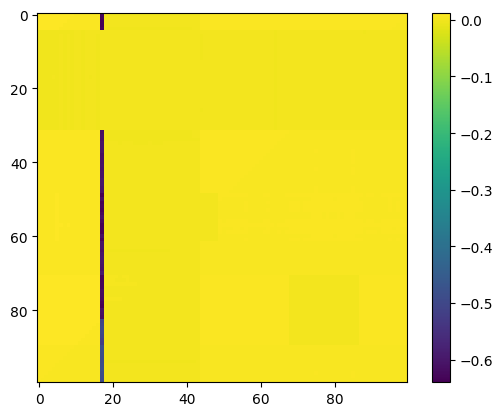

In [47]:
import matplotlib.pyplot as plt
plt.imshow(I)
plt.colorbar()
plt.savefig(f"IF_{test_idx}_alpha={alpha}_CoT.pdf")

In [48]:
# _I = torch.tensor(I)
# l = [i for i in range(100)]

# idx = torch.tensor(l)
# _I = torch.index_select(_I, 1, idx)
# plt.imshow(_I)
# plt.colorbar()

In [49]:
np.exp(I.min())

0.5272418017720988

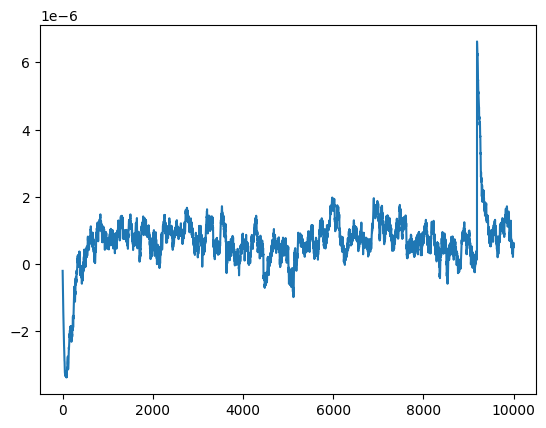

In [50]:
plt.plot(np.arange(len(Hv_list)), Hv_list)
plt.savefig(f"al={alpha}_it={iter_times}_test={test_idx}_d={0.01}_CoT.png")

In [56]:
np.argmin(I, axis=1)

array([17, 17, 17, 17, 17,  2,  0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

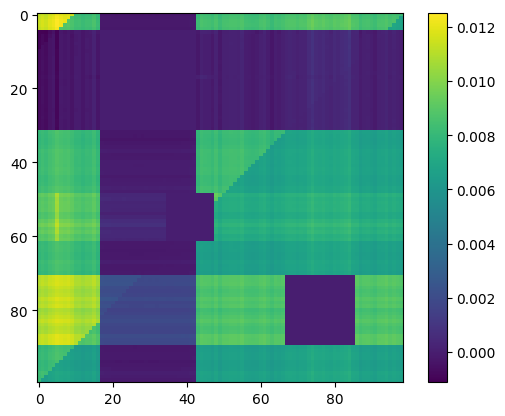

In [57]:
_I = torch.tensor(I)
l = [i for i in range(100)]
del l[17]
idx = torch.tensor(l)
_I = torch.index_select(_I, 1, idx)
plt.imshow(_I)
plt.colorbar()